# **Pix2Pix**

Implementación de "Image-to-Image Translation with Conditional Adversarial Networks"

Paper: https://arxiv.org/abs/1611.07004

Código: https://github.com/eriklindernoren/Keras-GAN/tree/master/pix2pix

Datasets: https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/

<img src="https://drive.google.com/uc?export=download&id=1vSakLQ9AUd8bBnIqQAVQ3ibrbwfFcxT_" align="center" style="float">

<img src="https://drive.google.com/uc?export=download&id=1htb7N7r_r3VvyF25OeHjOM8kKmYK4IUm" align="center" style="float">

In [ ]:
COLAB = True

In [ ]:
#%tensorflow_version 1.x

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-kxrax42y
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-kxrax42y
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=5c191d2eba3d835af381ba2acaf940cbd0a0002c4d739e65d52adcc2ef09b6b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-2b1cakmp/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1TG1gBklfNspXK-QfKL-GSjN4qRepglt0',
                                        dest_path='./data_loader.py')
    gdd.download_file_from_google_drive(file_id='1aRSTAlkF_rTZVHus7U8DW4rxsbY0aX-7',
                                        dest_path='./download_dataset.sh')

In [ ]:
#from __future__ import print_function, division

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os

In [ ]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'facades'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

In [ ]:
!chmod +x download_dataset.sh

In [ ]:
!ls -la

total 28
drwxr-xr-x 1 root root 4096 Jun 26 11:49 .
drwxr-xr-x 1 root root 4096 Jun 26 11:48 ..
drwxr-xr-x 4 root root 4096 Jun 15 13:37 .config
-rw-r--r-- 1 root root 2620 Jun 26 11:49 data_loader.py
-rwxr-xr-x 1 root root  263 Jun 26 11:49 download_dataset.sh
drwxr-xr-x 2 root root 4096 Jun 26 11:49 __pycache__
drwxr-xr-x 1 root root 4096 Jun 15 13:37 sample_data


In [ ]:
!./download_dataset.sh facades

for details.

--2021-06-26 11:49:25--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘./datasets/facades.tar.gz’

./datasets/facades. 100%[===================>]  28.77M  4.31MB/s    in 6.6s    

2021-06-26 11:49:32 (4.34 MB/s) - ‘./datasets/facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/

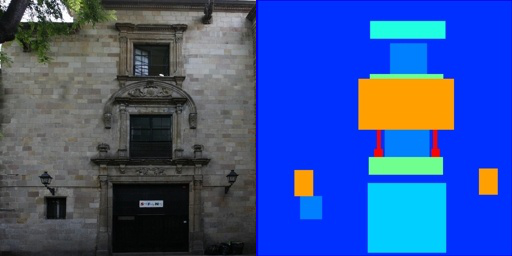

In [ ]:
from keras_preprocessing.image import load_img
img = load_img("./datasets/facades/val/5.jpg")
img

In [ ]:
gan = Pix2Pix()
gan.train(epochs=200, batch_size=1, sample_interval=200)

Se han truncado las últimas 5000 líneas del flujo de salida.
[Epoch 1/200] [Batch 25/400] [D loss: 0.179667, acc:  77%] [G loss: 34.647339] time: 0:02:18.662513
Leyendo imagen  ./datasets/facades/train/223.jpg
[Epoch 1/200] [Batch 26/400] [D loss: 0.276925, acc:  66%] [G loss: 28.190924] time: 0:02:18.860597
Leyendo imagen  ./datasets/facades/train/23.jpg
[Epoch 1/200] [Batch 27/400] [D loss: 0.162857, acc:  83%] [G loss: 28.638554] time: 0:02:19.057027
Leyendo imagen  ./datasets/facades/train/292.jpg
[Epoch 1/200] [Batch 28/400] [D loss: 0.121176, acc:  86%] [G loss: 39.269032] time: 0:02:19.291329
Leyendo imagen  ./datasets/facades/train/125.jpg
[Epoch 1/200] [Batch 29/400] [D loss: 0.181182, acc:  75%] [G loss: 43.445118] time: 0:02:19.484802
Leyendo imagen  ./datasets/facades/train/131.jpg
[Epoch 1/200] [Batch 30/400] [D loss: 0.274505, acc:  67%] [G loss: 35.186966] time: 0:02:19.679241
Leyendo imagen  ./datasets/facades/train/266.jpg
[Epoch 1/200] [Batch 31/400] [D loss: 0.316716

KeyboardInterrupt: ignored

In [ ]:
gan.img_shape

In [ ]:
gan.combined.save_weights("./pix2pix_combined.h5")
gan.discriminator.save_weights("./pix2pix_discriminator.h5")
gan.generator.save_weights("./pix2pix_generator.h5")

In [ ]:
for imgs_A, imgs_B in gan.data_loader.load_batch(16):
    # Condition on B and generate a translated version
    fake_A = gan.generator.predict(imgs_B)

Leyendo imagen  ./datasets/facades/train/135.jpg
Leyendo imagen  ./datasets/facades/train/332.jpg
Leyendo imagen  ./datasets/facades/train/98.jpg
Leyendo imagen  ./datasets/facades/train/369.jpg
Leyendo imagen  ./datasets/facades/train/70.jpg
Leyendo imagen  ./datasets/facades/train/271.jpg
Leyendo imagen  ./datasets/facades/train/365.jpg
Leyendo imagen  ./datasets/facades/train/187.jpg
Leyendo imagen  ./datasets/facades/train/280.jpg
Leyendo imagen  ./datasets/facades/train/65.jpg
Leyendo imagen  ./datasets/facades/train/262.jpg
Leyendo imagen  ./datasets/facades/train/268.jpg
Leyendo imagen  ./datasets/facades/train/15.jpg
Leyendo imagen  ./datasets/facades/train/329.jpg
Leyendo imagen  ./datasets/facades/train/43.jpg
Leyendo imagen  ./datasets/facades/train/316.jpg
Leyendo imagen  ./datasets/facades/train/293.jpg
Leyendo imagen  ./datasets/facades/train/207.jpg
Leyendo imagen  ./datasets/facades/train/62.jpg
Leyendo imagen  ./datasets/facades/train/225.jpg
Leyendo imagen  ./datasets

In [ ]:
imgs_A.shape, fake_A.shape, imgs_A.min(), imgs_A.max(), fake_A.min(), fake_A.max()

((16, 256, 256, 3), (16, 256, 256, 3), -1.0, 1.0, -0.97674865, 0.7815432)

In [ ]:
gan.dataset_name

'facades'

In [ ]:
for i0, i1 in zip(imgs_B, fake_A):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow((i0+1)/2)
    plt.subplot(1,2,2)
    plt.imshow((i1+1)/2)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.